In [1]:
using Catalyst: spatial_convert_err
include("../src/DiscreteStochasticSimulation.jl")
using .DiscreteStochasticSimulation
using Catalyst
using ProgressMeter
using Plots
using Expokit

## Lotka Volterra Chemical Reaction Network Definition using Catalyst.jl DSL

In [2]:
 local k₁, k₂, k₃, X, Y
  rn = @reaction_network begin
    k₁, X --> 2X
    k₂, X + Y --> 2Y
    k₃, Y --> 0
  end

Model ##ReactionSystem#231
Unknowns (2):
  X(t)
  Y(t)
Parameters (3):
  k₁
  k₂
  k₃

## Plug in the reaction network structure into the discrete system wrapper

In [3]:
model = DiscreteStochasticSystem(rn);

## Define boundary condition function

Rectangular lattice simply means the solver won't consider states beyond the limits

In [4]:
 # define boundaries (rectangular lattice in this case)
bounds = (0, 400) #(lower limit, upper limit)
boundary_condition(x) = RectLatticeBoundaryCondition(x, bounds);

## Define initial state and place it in a set, then expand the space 

In [5]:
# define initial value and expand the space a bit 
U₀ = CartesianIndex(100, 100)
X = Set([U₀])
X = Expand!(X, model, boundary_condition, 2);

## Define a probability density vector over the initial state space and set the probability of initial value to 1 (rest to zero)

In [6]:
 # initial probability vector (only for active states)
p₀ = zeros(X |> length)
p₀[DiscreteStochasticSimulation.FindElement(U₀, X)] = 1

# probability values for the entire state space (visalization only)
P = zeros(bounds[2], bounds[2]);
A = zeros(bounds[2], bounds[2]); # this will hold active states

## Run the simulation (sliding windows algorithm for fiite state projection)

t: 0.49, size: 149
t: 0.99, size: 149
t: 1.49, size: 149
t: 1.99, size: 149
t: 2.49, size: 144
t: 2.99, size: 144
t: 3.49, size: 144
t: 3.99, size: 143
t: 4.49, size: 144
t: 4.99, size: 152
t: 5.49, size: 147
t: 5.99, size: 152
t: 6.49, size: 155
t: 6.99, size: 149
t: 7.49, size: 149
t: 7.99, size: 153
t: 8.49, size: 154
t: 8.99, size: 153
t: 9.49, size: 150
t: 9.99, size: 152


[ Info: Saved animation to /Users/adityadendukuri/DiscreteStochasticSimulation/examples/anim_fps15.gif


Plots.AnimatedGif("/Users/adityadendukuri/DiscreteStochasticSimulation/examples/anim_fps15.gif")
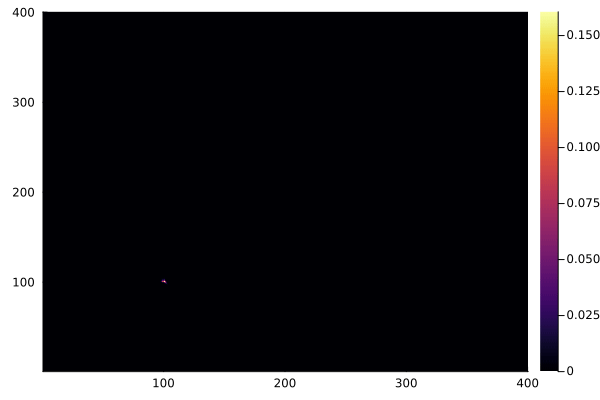

In [7]:
δt = 0.01
global iter = 0
global pₜ = p₀

a = @animate for t ∈ 0:0.01:10
    
  #expand space and assemble matrix
  global X, pₜ = Expand!(X, pₜ, model, boundary_condition, 7)
  A = MasterEquation(X, model, [1.0, 0.005, 0.6], boundary_condition, t)
    
  # solve system and normalize (using expokit (can also use numerical time steppers such as Runge-Kutta))
  global pₜ = expmv(δt, A, pₜ)
  pₜ /= sum(pₜ)
    
  # purge lowest 80% probability states (most will be zero; this is arbitrary as of now)
  X, pₜ = Purge!(X, pₜ, 70)
    
  # set probability values to full space for visualization using heatmap
  P .= 0 
  A .= 0
  P[X|>collect] = pₜ
  A[X|>collect] .= 1
  heatmap(P)

  # display timestep and system size 
  global iter = iter + 1
  if iter % 50 == 0
    println("t: $t, size: $(X |> collect |> length)")
  end
    
end every 5

gif(a, "anim_fps15.gif")